# Wafer Defect Detection

This notebook walks through the process of building and training a model to detect defects on semiconductor wafers.

## 1. Imports

Import all the necessary libraries.

In [71]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from scipy import interpolate
from scipy import stats

## 2. Model Definition

Here we define the Convolutional Neural Network (CNN) architecture.

In [72]:
def build_model(input_shape, num_classes):
    """
    Builds a convolutional neural network (CNN) for image classification.

    Args:
        input_shape (tuple): The shape of the input images (height, width, channels).
        num_classes (int): The number of classes for classification.

    Returns:
        keras.Model: The compiled CNN model.
    """
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## 3. Build and Summarize Model

Now, let's instantiate the model with our specific parameters and print its summary.

In [73]:
# Define dataset parameters
INPUT_SHAPE = (128, 128, 1)  # Example: 128x128 grayscale images
NUM_CLASSES = 9  # Example: 8 defect types + 1 normal

# Build the model
model = build_model(INPUT_SHAPE, NUM_CLASSES)

# Print the model summary
model.summary()

c:\Projects\Wafer-Defect-AI\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,657 (12.47 MB)

 Trainable params: 3,267,657 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Load Data

Load the wafer map data from the pickle file.

In [74]:
# The notebook is in the 'src' directory, so we go up one level to find the 'data' directory.
file_path = os.path.join('..', 'data', 'LSWMD.pkl')
df = pd.read_pickle(file_path)

# Display the first few rows to verify it loaded correctly
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


## 5. Preprocessing and Cleaning

Prepare the data for the model. This includes dropping unnecessary columns and converting labels into a numerical format.

In [75]:
# The 'waferIndex' is not needed for classification
df = df.drop(['waferIndex'], axis = 1)

df.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)

# Create new columns with numerical representations of the labels
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trainTestLabel
mapping_type = {'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest = {'Training':0, 'Test':1}
df = df.replace({'failureNum': mapping_type, 'trainTestNum': mapping_traintest})

# Train set
df_train = df[df["trainTestNum"] == 0]

# Test set
df_test = df[df["trainTestNum"] == 1]

# Unlabeled set (the ones that "don’t have anything")
df_unlabeled = df[df["trainTestNum"].isna()]

# Check the data types and non-null counts
df.head()

,waferMap,dieSize,lotName,trainTestLabel,failureType,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0


## 6. Data Exploration and Visualization

Let's visualize some of the wafer maps to get a feel for the data.

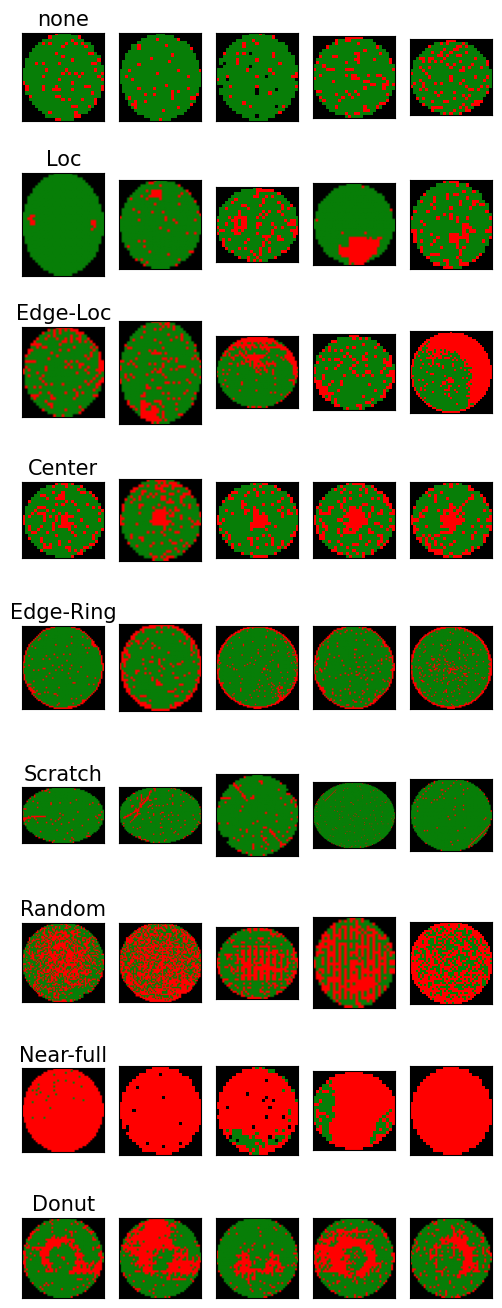

In [76]:
# Define a custom colormap
# 0: background (black)
# 1: good die (green)
# 2: defective die (red)
cmap = ListedColormap(['black', "#077e07", 'red'])

num_to_show = 5

unique_types = df_train["failureNum"].unique()   # includes 'none'

fig, axes = plt.subplots(nrows=len(unique_types), ncols=num_to_show, figsize=(5,1.5*len(unique_types)))

for row_idx, type in enumerate(unique_types):
    # sample 5 wafers of this type
    subset = df_train[df_train["failureNum"] == type].sample(n=num_to_show, random_state=42)

    for col_idx, wafer in enumerate(subset["waferMap"]):
        ax = axes[row_idx, col_idx]
        ax.imshow(wafer, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])

        if col_idx == 0:  # only label once per row
            label = subset.failureType.iloc[0][0][0]  # first element of the first row
            ax.set_title(label, fontsize=15, pad=5) 
plt.tight_layout()
plt.show()

## 7. Next Steps (TODO)

Now that the data is loaded and preprocessed, the next steps are:

- **Preprocess the images**: Resize, normalize, etc.
- **Split the data**: Divide the data into training and testing sets using the `trainTestNum` column.
- **Train the model**: Use `model.fit()` with the training data.
- **Evaluate the model**: Use `model.evaluate()` with the testing data.
- **Save the trained model**: Persist the trained model for future use.